In [1]:
import csv
import math
import sys, time
import networkx as nx
from pyomo.opt import SolverStatus, TerminationCondition
from pyomo.environ import *

In [2]:
G = nx.Graph()
pos = {}
site = {}

with open('CSV/first_graph/nodes_cost266.csv', 'r') as f_node:
    reader = csv.DictReader(f_node, delimiter=';', quotechar="'")
    for row in reader:
        node = int(row['node'])
        site_node = row['site']
        x_coord = float(row['X'])
        y_coord = float(row['Y'])
        G.add_node(node,site=site_node)
        pos[node] = [x_coord,y_coord]
        site[node] = site_node

In [3]:
with open('CSV/first_graph/edges_cost266.csv', 'r') as f_edge:
    reader = csv.DictReader(f_edge, delimiter=';', quotechar="'")
    for row in reader:
        nodeA = int(row['nodeA'])
        nodeB = int(row['nodeB'])
        G.add_edge(nodeA,nodeB)        
        G[nodeA][nodeB]['capa'] = float(row['capa'])

In [4]:
H = nx.DiGraph(G)
capa = {}

for (u,v) in G.edges():
    capa[(u,v)] = G[u][v]['capa']
    capa[(v,u)] = G[u][v]['capa']

In [5]:
K = nx.DiGraph()

with open('CSV/first_graph/demand_cost266.csv', 'r') as f_demand:
    reader = csv.DictReader(f_demand, delimiter=';', quotechar="'")
    for row in reader:
        nodeA = int(row['nodeA'])
        nodeB = int(row['nodeB'])
        if nodeA > nodeB:
            tmp = nodeA
            nodeA = nodeB
            nodeB = tmp
            
        K.add_edge(nodeA,nodeB)                    
        K[nodeA][nodeB]['demand'] = float(row['demand'])/25.0

In [6]:
print(len(G.nodes()),'nodes')
print(len(G.edges()),'edges')
print(len(K.edges()),'demands')

37 nodes
57 edges
36 demands


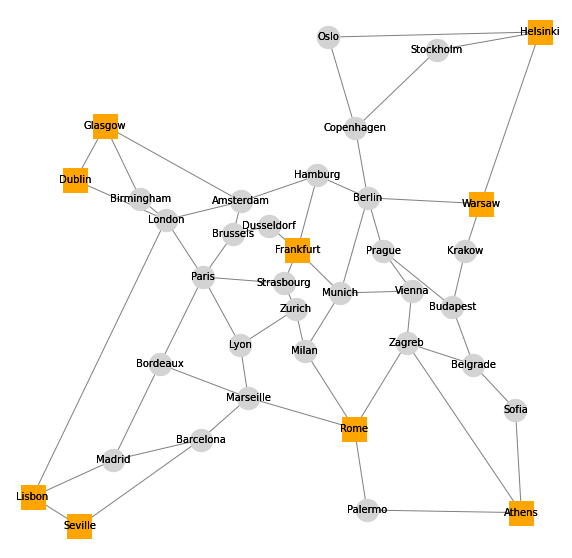

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,10));
plt.axis('off')

nx.draw_networkx_labels(G,pos,labels=site,font_size=10,font_color='black')

nx.draw(G, pos=pos, node_size=500, node_color='lightgrey', edge_color='grey')

nx.draw_networkx_labels(K,pos,labels=site,font_size=10,font_color='black')  
nx.draw_networkx_nodes(K, pos=pos, node_size=600, node_color='orange',node_shape='s')
plt.show()

In [8]:
#+++ Flow Conservation constraints +++
def flowConservation(model, node, o, d):
    inFlow = sum(
        model.flow[i,j,o,d] 
        for (i,j) in model.arcs 
        if j == node
    )
    outFlow = sum(
        model.flow[i,j,o,d] 
        for (i,j) in model.arcs 
        if i == node
    )
    if node == o:
        return (inFlow - outFlow + K[o][d]['demand'] == 0)
    elif node == d:
        return (inFlow - outFlow - K[o][d]['demand'] == 0) 
    else:
        return (inFlow == outFlow)

In [9]:
#+++ Capacity constraints +++
def linkCapacity(model, i, j):
    expression = sum(model.flow[i,j,o,d] + model.flow[j,i,o,d] for (o,d) in model.demands)<= model.capa[i,j] * model.gamma
    return expression

In [10]:
H.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37))

In [11]:
solver = 'glpk'

print('>>> Loading optimization model')
    
model = ConcreteModel()
    
model.dual = Suffix(direction=Suffix.IMPORT)

model.nodes   = Set(initialize=list(H.nodes))
model.links   = Set(initialize=list(G.edges()),dimen=2)
model.arcs    = Set(initialize=list(H.edges()),dimen=2)
model.demands = Set(initialize=list(K.edges()),dimen=2)

model.index1 = Set(initialize = [(u, o, d) for u in model.nodes for (o,d) in model.demands])
model.index2 = Set(initialize = [(u, v, o, d) for (u,v) in model.arcs for (o,d) in model.demands])

model.capa  = Param(model.arcs,initialize=capa)

model.flow  = Var(model.index2, domain=NonNegativeReals)
model.gamma = Var(domain=NonNegativeReals)

model.objective = Objective(rule=lambda m: m.gamma, sense=minimize)

model.flowConserv = Constraint(model.index1, rule=flowConservation)
    
model.linkCapa = Constraint(model.links, rule=linkCapacity)

>>> Loading optimization model


In [12]:
print('>>> Solving optimization model')
    
model.preprocess()

optim = SolverFactory(solver)
    
start_time = time.time()

results = optim.solve(model)
    
cpu_time = time.time() - start_time

print('+ TERM STAT:',results.solver.status)
print('+ TERM COND:',results.solver.termination_condition)
    
print('+ CPU  TIME = {0:.2f} s'.format(cpu_time))

if results.solver.status == SolverStatus.ok and results.solver.termination_condition != TerminationCondition.infeasible:
    print('+ OPT VAL  = {0:.8f}'.format(model.gamma.value))
    print('+ LWR BND  = {0:.2f}'.format(results.Problem._list[0]['Lower bound']))

>>> Solving optimization model
+ TERM STAT: ok
+ TERM COND: optimal
+ CPU  TIME = 0.32 s
+ OPT VAL  = 0.68820000
+ LWR BND  = 0.69


In [13]:
epsilon = 1.0e-06
    
for (u,v) in G.edges():
    TotalFlow = 0.0
    for (o,d) in K.edges():
        TotalFlow += model.flow[u,v,o,d].value
        TotalFlow += model.flow[v,u,o,d].value
    G[u][v]['flow'] = TotalFlow    
    if TotalFlow > epsilon:
        print('({},{}): {}'.format(u,v,TotalFlow/model.capa[(u,v)]))

(1,8): 0.2587150000000005
(1,19): 0.04278000000000032
(1,14): 0.6882000000000005
(1,15): 0.6812080000000001
(2,26): 0.1010199999999999
(2,36): 0.26698400000000005
(2,31): 0.16799999999999982
(3,30): 0.6881999999999998
(3,22): 0.6881999999999998
(4,9): 0.6881999999999998
(4,36): 0.14088
(4,31): 0.16799999999999987
(5,24): 0.27556666666666735
(5,10): 0.07
(5,35): 0.6882
(5,28): 0.15948500000000015
(5,15): 0.6881999999999999
(6,19): 0.6881999999999988
(6,14): 0.6881999999999988
(7,27): 0.6881999999999999
(7,21): 0.05904
(7,22): 0.19667999999999997
(8,27): 0.31357666666666634
(8,12): 0.46186666666666665
(9,17): 0.3440999999999998
(9,28): 0.6330666666666673
(10,32): 0.14
(11,19): 0.6881999999999999
(11,14): 0.4991
(12,13): 0.2771200000000001
(13,24): 0.6881999999999994
(13,33): 0.1947666666666676
(13,15): 0.6882000000000003
(16,32): 0.028
(16,35): 0.14746666666666666
(17,35): 0.6882
(18,19): 0.6881999999999993
(18,21): 0.0738
(18,30): 0.2392333333333332
(19,27): 0.38749999999999934
(20,27):

In [14]:
for (o,d) in K.edges():
    print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']*model.gamma.value))
    for (u,v) in model.arcs:
        if model.flow[u,v,o,d].value > epsilon:
            print('\tarc ({0:s},{1:s}): flow = {2:f}'.format(site[u],site[v],model.flow[u,v,o,d].value))

demand (Athens,Dublin): 0.991008
	arc (Athens,Zagreb): flow = 1.440000
	arc (Bordeaux,Paris): flow = 1.440000
	arc (London,Dublin): flow = 1.440000
	arc (Marseille,Bordeaux): flow = 1.440000
	arc (Paris,London): flow = 1.440000
	arc (Rome,Marseille): flow = 1.440000
	arc (Zagreb,Rome): flow = 1.440000
demand (Athens,Frankfurt): 6.992112
	arc (Athens,Zagreb): flow = 10.160000
	arc (Milan,Zurich): flow = 10.160000
	arc (Munich,Milan): flow = 0.587000
	arc (Rome,Milan): flow = 9.573000
	arc (Strasbourg,Frankfurt): flow = 10.160000
	arc (Vienna,Munich): flow = 0.587000
	arc (Zagreb,Rome): flow = 9.573000
	arc (Zagreb,Vienna): flow = 0.587000
	arc (Zurich,Strasbourg): flow = 10.160000
demand (Athens,Glasgow): 9.166824
	arc (Athens,Zagreb): flow = 13.320000
	arc (Bordeaux,Paris): flow = 13.320000
	arc (Dublin,Glasgow): flow = 13.320000
	arc (London,Dublin): flow = 13.320000
	arc (Marseille,Bordeaux): flow = 13.320000
	arc (Paris,London): flow = 13.320000
	arc (Rome,Marseille): flow = 13.3200

In [27]:
dist = {}
for (u, v) in list(G.edges()):
    dist[(u,v)] = math.sqrt((pos[u][0]-pos[v][0])**2+(pos[u][1]-pos[v][1])**2)
dist

{(1, 8): 1.6164467204334358,
 (1, 19): 5.140758698869264,
 (1, 14): 9.79655551711927,
 (1, 15): 5.258745097454333,
 (2, 26): 10.380693618443809,
 (2, 36): 10.988766991796668,
 (2, 31): 4.766812352086036,
 (3, 30): 9.083264831545977,
 (3, 21): 5.975993641228209,
 (3, 22): 3.7284044844946744,
 (4, 9): 3.0241197066253864,
 (4, 36): 4.590250537824706,
 (4, 31): 3.5121645747316546,
 (5, 24): 4.756153908359149,
 (5, 10): 3.3058886853613165,
 (5, 35): 7.604794540288383,
 (5, 28): 2.648490135907631,
 (5, 15): 3.5334544004415838,
 (6, 19): 1.9659603251337494,
 (6, 14): 4.128110948121431,
 (7, 27): 4.956853840895449,
 (7, 21): 5.435752017890441,
 (7, 22): 6.13890055303065,
 (8, 27): 2.814604767991414,
 (8, 12): 2.4627017683836594,
 (9, 17): 2.694327374318122,
 (9, 28): 5.317790894723107,
 (10, 32): 6.562202374203344,
 (10, 25): 4.586556442474028,
 (11, 19): 6.349433045556115,
 (11, 14): 3.217203754815665,
 (12, 13): 2.202044504545716,
 (13, 24): 3.5058379882704216,
 (13, 33): 1.766465397340126,


In [51]:
solver = 'glpk'

T_max = 7000

print('>>> Loading optimization model')
    
model = ConcreteModel()
    
model.dual = Suffix(direction=Suffix.IMPORT)

model.nodes   = Set(initialize=list(H.nodes))
model.links   = Set(initialize=list(G.edges()),dimen=2)
model.arcs    = Set(initialize=list(H.edges()),dimen=2)
model.demands = Set(initialize=list(K.edges()),dimen=2)

model.index1 = Set(initialize = [(u, o, d) for u in model.nodes for (o,d) in model.demands])
model.index2 = Set(initialize = [(u, v, o, d) for (u,v) in model.arcs for (o,d) in model.demands])

model.capa  = Param(model.arcs,initialize=capa)

model.flow  = Var(model.index2, domain=NonNegativeReals)
model.gamma = Var(domain=NonNegativeReals)

model.objective = Objective(rule=lambda m: m.gamma, sense=minimize)

model.flowConserv = Constraint(model.index1, rule=flowConservation)
model.linkCapa = Constraint(model.links, rule=linkCapacity)
model.time = Constraint(expr=sum(dist[(u,v)]*model.flow[u,v,o,d] for (u,v) in dist.keys() for (o,d) in  model.demands) <= T_max)

>>> Loading optimization model


In [52]:
print('>>> Solving optimization model')
    
model.preprocess()

optim = SolverFactory(solver)
    
start_time = time.time()

results = optim.solve(model)
    
cpu_time = time.time() - start_time

print('+ TERM STAT:',results.solver.status)
print('+ TERM COND:',results.solver.termination_condition)
    
print('+ CPU  TIME = {0:.2f} s'.format(cpu_time))

if results.solver.status == SolverStatus.ok and results.solver.termination_condition != TerminationCondition.infeasible:
    print('+ OPT VAL  = {0:.8f}'.format(model.gamma.value))
    print('+ LWR BND  = {0:.2f}'.format(results.Problem._list[0]['Lower bound']))

>>> Solving optimization model
+ TERM STAT: ok
+ TERM COND: optimal
+ CPU  TIME = 0.37 s
+ OPT VAL  = 0.93437010
+ LWR BND  = 0.93


In [53]:
epsilon = 1.0e-06
    
for (u,v) in G.edges():
    TotalFlow = 0.0
    for (o,d) in K.edges():
        TotalFlow += model.flow[u,v,o,d].value
        TotalFlow += model.flow[v,u,o,d].value
    G[u][v]['flow'] = TotalFlow    
    if TotalFlow > epsilon:
        print('({},{}): {}'.format(u,v,TotalFlow/model.capa[(u,v)]))

(1,8): 0.061807475367490684
(1,14): 0.6278459802939926
(1,15): 0.5784000000000001
(2,31): 0.3502
(3,30): 0.2698
(3,22): 0.2698
(4,9): 0.8400299014699629
(4,36): 0.46193196058798514
(4,31): 0.3502
(5,24): 0.812163234803296
(5,10): 0.0191700985300372
(5,35): 0.830177940881978
(5,28): 0.2648
(5,15): 0.7029850492650186
(6,19): 0.934370098530038
(6,14): 0.934370098530038
(7,27): 0.934370098530037
(7,21): 0.3417659802939926
(7,22): 0.15489196058798513
(8,27): 0.08293831691166051
(8,12): 0.08346666666666652
(9,17): 0.22246168308833925
(9,28): 0.5910367651967033
(10,32): 0.0383401970600744
(11,19): 0.7160000000000001
(11,14): 0.5642
(12,13): 0.050080000000000194
(13,24): 0.5771149507349844
(13,33): 0.5330000000000021
(13,15): 0.0783700985300373
(16,32): 0.007668039412014878
(16,35): 0.16440996715665426
(17,35): 0.4449233661766785
(18,19): 0.934370098530038
(18,21): 0.4272074753674907
(18,30): 0.4726666666666666
(19,27): 0.4773333333333334
(20,37): 0.4028000000000001
(20,22): 0.2013999999999999